# Classification d’images d’hématies

![alt text](../Capture.PNG)

### Introduction 

Contexte et Importance du Projet
Le paludisme, une maladie infectieuse grave transmise par les moustiques, affecte des millions de personnes chaque année, principalement dans les régions tropicales et subtropicales. La détection précoce et précise de cette maladie est cruciale pour un traitement efficace et pour réduire la mortalité. Cependant, le diagnostic repose souvent sur l'examen microscopique des frottis sanguins, une procédure longue et nécessitant une expertise médicale spécialisée.

### Objectif du Projet  

L'objectif de ce projet est de développer et d'entraîner un modèle de réseau de neurones convolutifs (CNN) capable de différencier les hématies infectées par le paludisme de celles qui sont saines. Un tel modèle pourrait considérablement accélérer le processus de diagnostic et augmenter sa précision, en offrant une assistance automatisée aux professionnels de santé.

### Structure du Projet 

Ce projet se déroulera en plusieurs étapes clés :

   - Manipulation de la Donnée : Préparation et augmentation des données pour l'entraînement des modèles.
   - Entraînement de Modèles : Implémentation et entraînement de trois modèles CNN différents.
   - Évaluation des Modèles : Test et évaluation des performances des modèles sur un jeu de données de test.

## Manipulation de la donnée

Import des librairies

In [1]:
import os
import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Chargement des données

In [3]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv.imread(img_path)
        if img is not None:
            # Redimensionner les images à 128x128
            img = cv.resize(img, (128, 128))  
            images.append(img)
            labels.append(label)
    return np.array(images), labels

Chemin vers les données

In [4]:
parasitized_paths = "../dataset/parasitized"
uninfected_paths = "../dataset/uninfected"

Charger les images et leurs labels

In [5]:
parasitized_images, parasitized_labels = load_images_from_folder(parasitized_paths, 'parasitized')
uninfected_images, uninfected_labels = load_images_from_folder(uninfected_paths, 'uninfected')

Combiner les images et les labels

In [7]:
images = np.concatenate((parasitized_images, uninfected_images), axis=0)
labels = np.concatenate((parasitized_labels, uninfected_labels), axis=0)

Normalisation des images 

In [9]:
images =  np.array(images) / 255.0

Encoder les labels

In [10]:
label_encoder = LabelEncoder()
labels_LabelEncoder = label_encoder.fit_transform(labels)

Mélange des données

In [12]:
combined_data = list(zip(images, labels_LabelEncoder))

np.random.shuffle(combined_data)

shuffled_images, shuffled_labels = zip(*combined_data)

Shapes et nombre des labels

In [13]:
print("Shape of Images:", images.shape)
print("Length of Labels:", len(labels_LabelEncoder))

Shape of Images: (27558, 128, 128, 3)
Length of Labels: 27558


Création des jeux de test, train

In [14]:
X_train, X_test, y_train, y_test = train_test_split(shuffled_images, shuffled_labels, test_size=0.3, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Création du générateur pour la data augmentation

In [16]:
datagen = ImageDataGenerator(
    rotation_range=20,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    zoom_range=0.1,  
    horizontal_flip=True
)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(x = X_train,
                                     y = y_train.reshape(-1, 1),
                                     batch_size = 32)

test_generator = train_datagen.flow(x = X_test,
                                     y = y_test.reshape(-1, 1),
                                     batch_size = 32)

Affichage d'images augmentées

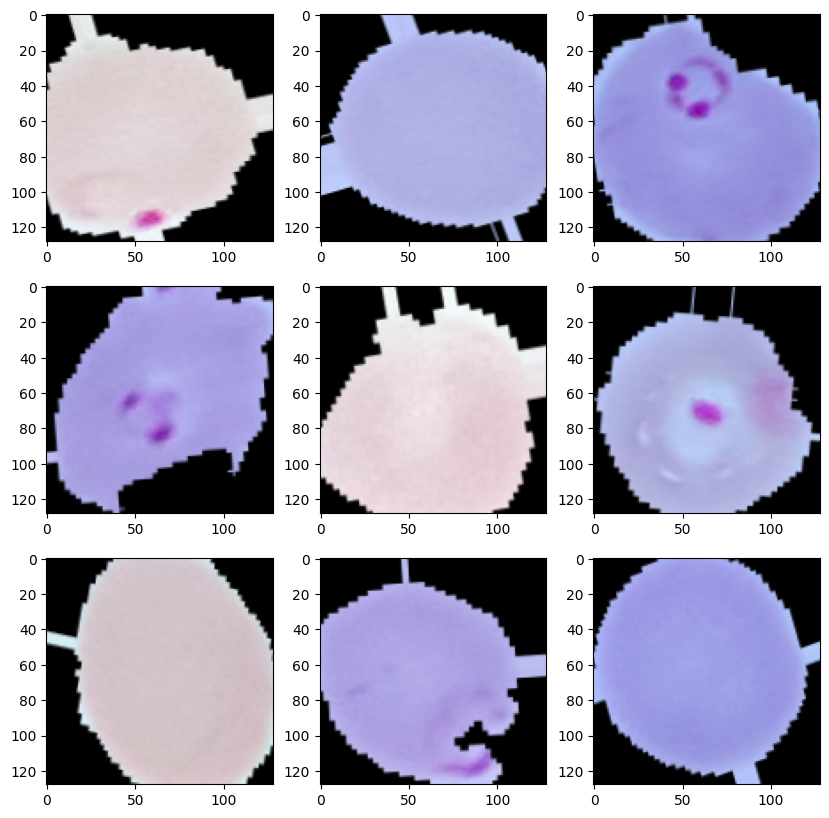

In [18]:
plt.figure(figsize=(10, 10))
for X_batch, y_batch in datagen.flow(images, labels, batch_size=9):
    for i in range(0, 9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_batch[i])
    plt.show()
    break

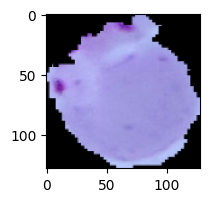

In [19]:
plt.figure(figsize=(2, 2))
plt.imshow(X_train[45])
plt.show()


# Création des modèles

Définiton des callbacks

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras

Implémentation des callbacks

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-4)

## Création d'un modèle CNN avec tensorflow/Keras

In [22]:
num_classes = 1

In [23]:
model_from_scratch = Sequential([
    keras.Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')
])

c:\hetic\Hetic-MD4\Machine learning\paludisme\venv_paludimse\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compiler le modèle

In [24]:
model_from_scratch.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Fine-tuning du VGG16 pré-entraîné sur ImageNet

Import des librairies

In [25]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

Chargement du modèle VGG16 pré-entraîné

In [26]:
vgg16_encodeur = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

vgg16_model_finetuned = keras.Sequential([
    vgg16_encodeur,
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

Compilation du modèle

In [27]:
vgg16_model_finetuned.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

## Fine-tuning du ResNet50 pré-entraîné sur ImageNet

In [28]:
from tensorflow.keras.applications import ResNet50

Chargement du modèle ResNet50 pré-entraîné

In [29]:
first_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

Ajout des couches denses pour l'adaptation finale

In [30]:
model_resnet50 = Sequential([
    first_model_resnet50,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

Compilation du resnet50

In [31]:
model_resnet50.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement des 3 modèles 

Entraînement du modèle from scratch

In [32]:
# Train the model
history_from_scratch = model_from_scratch.fit(
    train_generator,
    epochs=10,
    validation_data=(X_test, y_test.reshape(-1, 1)),
    callbacks=[early_stopping, learning_rate_decay]
)

Epoch 1/10


c:\hetic\Hetic-MD4\Machine learning\paludisme\venv_paludimse\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


603/603 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - accuracy: 0.6489 - loss: 0.6112 - val_accuracy: 0.9331 - val_loss: 0.1913 - learning_rate: 0.0010
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 67s 110ms/step - accuracy: 0.9312 - loss: 0.2038 - val_accuracy: 0.9559 - val_loss: 0.1428 - learning_rate: 0.0010
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 67s 111ms/step - accuracy: 0.9438 - loss: 0.1763 - val_accuracy: 0.9562 - val_loss: 0.1400 - learning_rate: 0.0010
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 68s 112ms/step - accuracy: 0.9507 - loss: 0.1623 - val_accuracy: 0.9612 - val_loss: 0.1270 - learning_rate: 0.0010
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step - accuracy: 0.9496 - loss: 0.1595 - val_accuracy: 0.9594 - val_loss: 0.1275 - learning_rate: 0.0010
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.9518 - loss: 0.1507 - val_accuracy: 0.9595 - val_loss: 0.1293 - learning_rate: 0.0010
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 67s 110ms/step - accuracy: 0.9531 - loss:

Entraînement du modèle

In [33]:
history_vgg16 = vgg16_model_finetuned.fit(
    train_generator,
    epochs=10,
    validation_data=(X_test, y_test.reshape(-1,1)),
    callbacks=[early_stopping, learning_rate_decay]
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 859s 1s/step - accuracy: 0.6667 - loss: 0.7153 - val_accuracy: 0.9566 - val_loss: 0.1537 - learning_rate: 0.0010
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 1123s 2s/step - accuracy: 0.9500 - loss: 0.1646 - val_accuracy: 0.9588 - val_loss: 0.1349 - learning_rate: 0.0010
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 860s 1s/step - accuracy: 0.9524 - loss: 0.1531 - val_accuracy: 0.9611 - val_loss: 0.1286 - learning_rate: 0.0010
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 864s 1s/step - accuracy: 0.9526 - loss: 0.1546 - val_accuracy: 0.9602 - val_loss: 0.1299 - learning_rate: 0.0010
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 863s 1s/step - accuracy: 0.9536 - loss: 0.1483 - val_accuracy: 0.9589 - val_loss: 0.1277 - learning_rate: 0.0010


Entraînement du resnet50 

In [34]:
history_resnet50 = model_resnet50.fit(
    train_generator,
    validation_data=(X_test, y_test.reshape(-1,1)),
    epochs=10,  
    callbacks=[early_stopping, learning_rate_decay]
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 548s 870ms/step - accuracy: 0.9025 - loss: 0.2945 - val_accuracy: 0.5129 - val_loss: 1.6629 - learning_rate: 0.0010
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 516s 854ms/step - accuracy: 0.9523 - loss: 0.1537 - val_accuracy: 0.9439 - val_loss: 0.2609 - learning_rate: 0.0010
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 517s 857ms/step - accuracy: 0.9542 - loss: 0.1563 - val_accuracy: 0.9370 - val_loss: 0.2139 - learning_rate: 0.0010
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 514s 852ms/step - accuracy: 0.9537 - loss: 0.1442 - val_accuracy: 0.9588 - val_loss: 0.1318 - learning_rate: 0.0010
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 522s 865ms/step - accuracy: 0.9547 - loss: 0.1403 - val_accuracy: 0.9595 - val_loss: 0.1228 - learning_rate: 0.0010


Sauvegarde des poids des modèles

In [35]:
model_from_scratch.save('keras_from_scratch_weights.h5')

vgg16_model_finetuned.save('vgg16_weights.h5')

model_resnet50.save('resnet50_weights.h5')

# Test des modèles 

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import VGG16, ResNet50

Évaluation des modèles et calcul de la matrice de confusion

In [38]:
def calculate_confusion_matrix(model, test_data, test_labels):
    predictions = model.predict(test_data)
    predicted_classes = np.argmax(predictions, axis=1)
    cm = confusion_matrix(test_labels, predicted_classes)
    return cm

Calcul de la matrice de confusion pour chaque modèle

Matrice de confusion du from scratch

In [39]:
cm_scratch = calculate_confusion_matrix(model_from_scratch, X_test, y_test)
print(cm_scratch)


259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
[[4027    0]
 [4241    0]]


Matrice de confusion du vgg16

In [40]:
cm_vgg16 = calculate_confusion_matrix(vgg16_model_finetuned, X_test, y_test)
print(cm_vgg16)


259/259 ━━━━━━━━━━━━━━━━━━━━ 100s 387ms/step
[[4027    0]
 [4241    0]]


Matrice de confusion du resnet50

In [41]:
cm_resnet50 = calculate_confusion_matrix(model_resnet50, X_test, y_test)
print(cm_resnet50)


259/259 ━━━━━━━━━━━━━━━━━━━━ 49s 184ms/step
[[4027    0]
 [4241    0]]


Calcul des métriques de performance et affichage

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [43]:
def calculate_metrics(cm):
    accuracy = np.trace(cm) / np.sum(cm)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    # Calcul de la précision, rappel, f1-score moyen
    precision_avg = np.nanmean(precision)
    recall_avg = np.nanmean(recall)
    f1_avg = np.nanmean(f1)
    
    # Calcul de la sensibilité et spécificité pour chaque classe
    sensitivity = recall  # sensibilité est le même que recall
    specificity = []
    for i in range(len(cm)):
        true_negatives = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        false_positives = np.sum(cm[:, i]) - cm[i, i]
        specificity.append(true_negatives / (true_negatives + false_positives))
    specificity_avg = np.nanmean(specificity)
    
    return accuracy, precision_avg, recall_avg, f1_avg, sensitivity, specificity_avg

In [44]:
def display_model_metrics(model_name, accuracy_scratch, precision_scratch, recall_scratch, f1_scratch, sensitivity_scratch, specificity_scratch):
    print(f"{model_name}")
    print(f"Accuracy: {accuracy_scratch}")
    print(f"Precision: {precision_scratch}")
    print(f"Recall: {recall_scratch}")
    print(f"F1-Score: {f1_scratch}")
    print(f"Sensitivity: {sensitivity_scratch}")
    print(f"Specificity: {specificity_scratch}")
    print()


Calcul des métriques de chaque modèle

In [45]:
# Calcul des métriques pour le modèle scratch
accuracy_scratch, precision_scratch, recall_scratch, f1_scratch, sensitivity_scratch, specificity_scratch = calculate_metrics(cm_scratch)

# Calcul des métriques pour le modèle VGG16 fine-tuning
accuracy_vgg16, precision_vgg16, recall_vgg16, f1_vgg16, sensitivity_vgg16, specificity_vgg16 = calculate_metrics(cm_vgg16)

# Calcul des métriques pour le modèle ResNet50 fine-tuning
accuracy_resnet50, precision_resnet50, recall_resnet50, f1_resnet50, sensitivity_resnet50, specificity_resnet50 = calculate_metrics(cm_resnet50)

C:\Users\thibo\AppData\Local\Temp\ipykernel_72036\2306002397.py:3: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(cm) / np.sum(cm, axis=0)


Affichage des métriques

In [46]:
display_model_metrics("model from scratch", accuracy_scratch, precision_scratch, recall_scratch, f1_scratch, sensitivity_scratch, specificity_scratch)
display_model_metrics("model vgg16", accuracy_vgg16, precision_vgg16, recall_vgg16, f1_vgg16, sensitivity_vgg16, specificity_vgg16)
display_model_metrics("model resnet50",accuracy_resnet50, precision_resnet50, recall_resnet50, f1_resnet50, sensitivity_resnet50, specificity_resnet50)

model from scratch
Accuracy: 0.4870585389453314
Precision: 0.4870585389453314
Recall: 0.5
F1-Score: 0.6550630337535583
Sensitivity: [1. 0.]
Specificity: 0.5

model vgg16
Accuracy: 0.4870585389453314
Precision: 0.4870585389453314
Recall: 0.5
F1-Score: 0.6550630337535583
Sensitivity: [1. 0.]
Specificity: 0.5

model resnet50
Accuracy: 0.4870585389453314
Precision: 0.4870585389453314
Recall: 0.5
F1-Score: 0.6550630337535583
Sensitivity: [1. 0.]
Specificity: 0.5



Affichage des gragphiques ROC et calcul du AUC

In [47]:
from sklearn.metrics import roc_curve, auc

In [48]:
def plot_roc_auc(model, test_generator, num_classes):
    y_pred = model.predict(test_generator)
    
    y_true = []
    num_batches = len(test_generator)
    for i in range(num_batches):
        _, batch_y_true = test_generator[i]
        y_true.extend(batch_y_true)
    
    y_true = np.array(y_true)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Calcul de l'AUC moyen (macro)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Tracer toutes les courbes ROC
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc


ROC du modèle From scratch

c:\hetic\Hetic-MD4\Machine learning\paludisme\venv_paludimse\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


259/259 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step


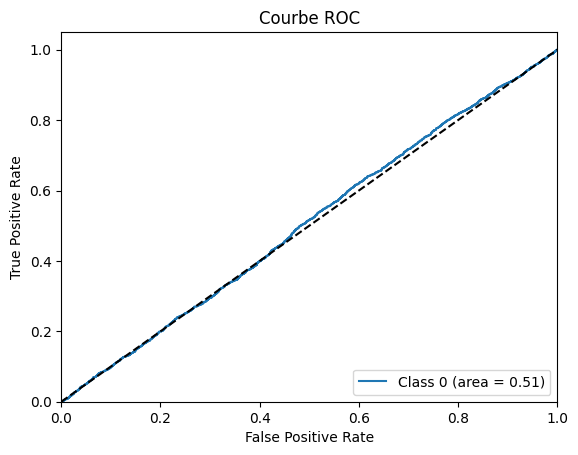

Scratch Model AUC: 0.5067525516135574


In [50]:
# ROC et AUC pour le modèle scratch
roc_auc_scratch = plot_roc_auc(model_from_scratch, test_generator, num_classes)
print(f"Scratch Model AUC: {roc_auc_scratch['macro']}")

ROC du vgg16

259/259 ━━━━━━━━━━━━━━━━━━━━ 103s 397ms/step


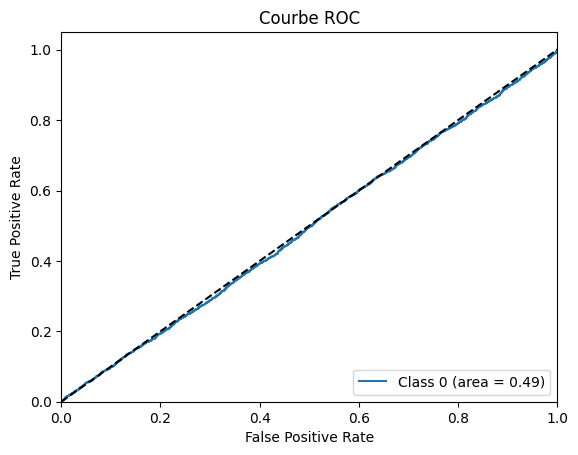

VGG16 Fine-Tuning Model AUC: 0.495032469758627


In [51]:
# ROC et AUC pour le modèle VGG16 fine-tuning
roc_auc_vgg16 = plot_roc_auc(vgg16_model_finetuned, test_generator, num_classes)
print(f"VGG16 Fine-Tuning Model AUC: {roc_auc_vgg16['macro']}")

resnet50

259/259 ━━━━━━━━━━━━━━━━━━━━ 50s 187ms/step


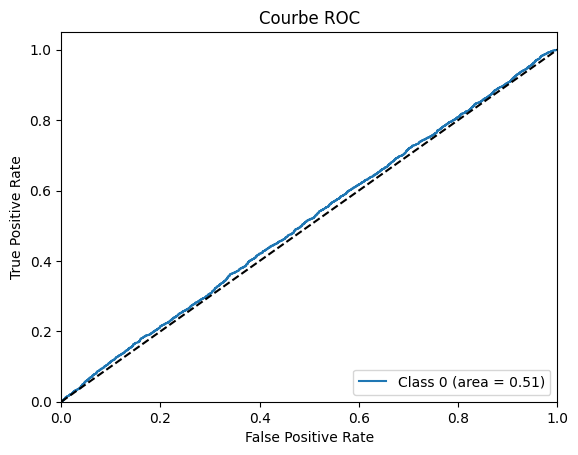

ResNet50 Fine-Tuning Model AUC: 0.5126725070288638


In [52]:
# ROC et AUC pour le modèle ResNet50 fine-tuning
roc_auc_resnet50 = plot_roc_auc(model_resnet50, test_generator, num_classes)
print(f"ResNet50 Fine-Tuning Model AUC: {roc_auc_resnet50['macro']}")

# Conclusion


On obtient dans les trois cas un graphique ROC linéaire, ce qui montre que l'entraînement n'est pas concluant. Ces CNN ne sont pas précis du tout, une chance sur deux de se tromper dans les prédictions pour n'importe quel cas. 

De plus, on observe que les matrices de confusion ne renvoit que des true positif et false positif rien d'autre (cela fausse les calculs).